## Test LaSR datasets

In [74]:
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
import dataset_utils
from importlib import reload
reload(dataset_utils)


<module 'dataset_utils' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [75]:
dataset_utils.create_datasets('synthetic', 100, 1e-4, equation_indices=[0])

[SyntheticDataset(idx=0, equation="y = exp(((1.485035504085099 - log(y2)) / (-0.5917667741788188 - y4)) + (sqrt(y1 + y4) + sqrt(y2)))", X=(100, 5), Y=(100,), var_order={'x0': 'y3', 'x1': 'y1', 'x2': 'y5', 'x3': 'y4', 'x4': 'y2'})]

Note: Expressions from synthetic dataset without log or sqrt are:
[5, 9, 16, 20, 25, 31, 32, 36, 39]

## PySR integration tests

In [1]:
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
import dataset
import matplotlib.pyplot as plt

In [28]:
import pysr_interface_utils
reload(pysr_interface_utils)
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats

In [2]:
from pysr import PySRRegressor
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats
import numpy as np
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
from importlib import reload
import dataset
reload(dataset)
from dataset import synthetic_dataset

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling SymbolicRegression...
  34122.4 ms  ✓ SymbolicRegression
  1 dependency successfully precompiled in 35 seconds. 123 already precompiled.
Precompiling SymbolicRegressionJSON3Ext...
   2052.0 ms  ✓ SymbolicRegression → SymbolicRegressionJSON3Ext
  1 dependency successfully precompiled in 2 seconds. 128 already precompiled.


In [80]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "tanh",
            "cosh",
            "sinh"
        ],
        precision=64,
        neural_options=dict(
            active=True,
            model_path="/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-zwrgtnj0.onnx",
            sampling_eps=0.01,
            subtree_min_nodes=2,
            subtree_max_nodes=10,
        ),
        weight_neural_mutate_tree=0.0,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})"
    )
    model.fit(X, y)
    return model

In [79]:
dataset = dataset_utils.create_datasets('synthetic', num_samples=2000, noise=0, equation_indices=[9])[0]
dataset.equation

'y = y1 * (((y1 * y1) / (2.189911201366985 / cos((1.2114819663272414 - y4) + -0.20111570724898717))) / exp(-0.08661496242802426 * y5))'

In [81]:
reset_mutation_stats()
model = eval_equation(dataset.X, dataset.Y, n_iterations=10, early_stopping_condition=1e-8)


stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']

/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/pysr/sr.py:2785: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 6.110e+04
Progress: 222 / 310 total iterations (71.613%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.432e+10  3.604e+01  y = 6.5622
2           4.420e+10  2.781e-03  y = sin(x₃)
3           4.414e+10  1.149e-03  y = exp(sin(x₃))
4           3.035e+10  3.748e-01  y = sin(x₃) * 168.22
6           2.038e+10  1.992e-01  y = (sin(x₃) * x₄) * 36.342
8           1.676e+10  9.763e-02  y = (x₄ * (x₄ * sin(x₃))) * 5.07
9           1.639e+10  2.230e-02  y = x₄ * (x₁ * (sin(sin(x₃)) * x₄))
10          3.318e+09  1.597e+00  y = (x₄ * sin(x₃ + 0.56768)) * (x₄ / 0.15892)
12          3.263e+09  8.382e-03  y = sin(x₃ + 0.66057) * (x₄ * (x₄ * (x₁ - -0.25252)))
14          2.245e+09  1.870e-01  y = ((sin(x₃ + 0.56524) * ((x₄ * 10.32) - 32.006)) * x₄) +...
    

ValueError: min() iterable argument is empty

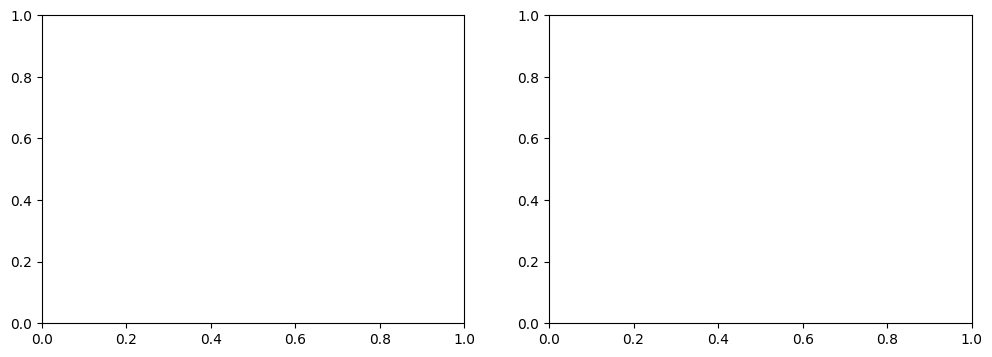

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


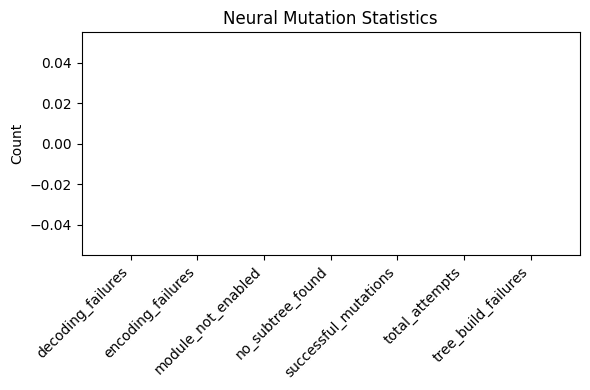

In [83]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)} 

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(count_stats.keys(), count_stats.values())
plt.xticks(rotation=45, ha='right')
plt.title('Neural Mutation Statistics')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [32]:
count_stats

{'decoding_failures': 0,
 'encoding_failures': 0,
 'module_not_enabled': 5036,
 'no_subtree_found': 0,
 'successful_mutations': 0,
 'total_attempts': 5036,
 'tree_build_failures': 0}